<a href="https://colab.research.google.com/github/pavankonam/Face_Mask_Detection/blob/main/Covid_19_Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount Google drive to colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load the dataset and change into the Directory** 

In [ ]:
%cd /content/drive/MyDrive/Face-Mask-Detection-master

/content/drive/MyDrive/Face-Mask-Detection-master


In [ ]:
%pwd

'/content/drive/MyDrive/Face-Mask-Detection-master'

**Train** **Model** or **skip if you trained the model before and load it**

In [ ]:
!python train_mask_detector.py --dataset dataset

2021-07-19 19:57:28.114527: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
[INFO] loading images...
Traceback (most recent call last):
  File "train_mask_detector.py", line 41, in <module>
    for img in os.listdir(path):
FileNotFoundError: [Errno 2] No such file or directory: '\\dataset/with_mask'


**camera** **capture**

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


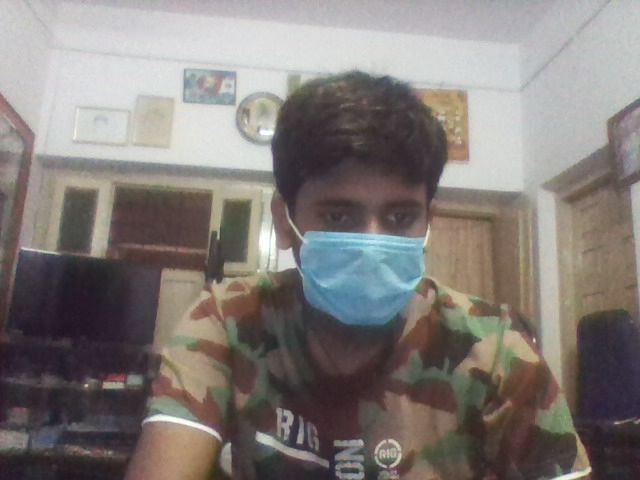

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

**Run the face mask detection on recorded image**

[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] computing face detections...


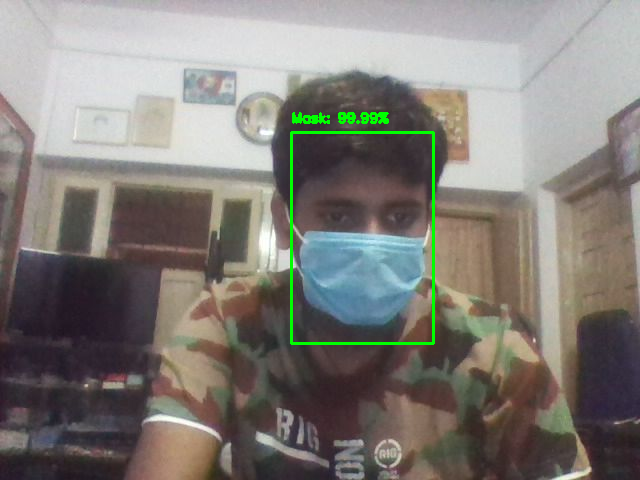

In [ ]:
# USAGE
# Give input image file path (check other paths also)

# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os
from google.colab.patches import cv2_imshow
from natsort import natsorted, ns

input_file_path = "/content/drive/MyDrive/Face-Mask-Detection-master/photo.jpg"

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = "/content/drive/My Drive/Face-Mask-Detection-master/face_detector/deploy.prototxt"
weightsPath = "/content/drive/My Drive/Face-Mask-Detection-master/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model("/content/drive/MyDrive/Face-Mask-Detection-master/mask_detector.model")

def process_images(input_file_path):
	# load the input image from disk, clone it, and grab the image spatial
  # dimensions
	image = cv2.imread(input_file_path)
	# orig = image.copy()
	(h, w) = image.shape[:2]

	# construct a blob from the image
	blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	print("[INFO] computing face detections...")
	net.setInput(blob)
	detections = net.forward()

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = image[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)
			face = np.expand_dims(face, axis=0)

			# pass the face through the model to determine if the face
			# has a mask or not
			(mask, withoutMask) = model.predict(face)[0]

			# determine the class label and color we'll use to draw
			# the bounding box and text
			label = "Mask" if mask > withoutMask else "No Mask"
			color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

			# include the probability in the label
			label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

			# display the label and bounding box rectangle on the output
			# frame
			cv2.putText(image, label, (startX, startY - 10),
				cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
			cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

	# show the output image
	save_path = input_file_path.split(".",1)
	# print (save_path[0])
	# print (save_path[-1])
	cv2_imshow(image)
	# cv2.imwrite(save_path[0] + "_pred." + save_path[-1],image)

#start the process
process_images(input_file_path)